In [13]:
import numpy as np
import  random  
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [14]:
# Load the experiment data
mem = Memory("./mycache")

@mem.cache
def get_data(path,feature):
    data = load_svmlight_file(path,feature)    
    return data

In [15]:
def predict(W , X, y ,threshold):
    """
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - x: A numpy array of shape (N, D) containing a minibatch of training data.
    - y: A numpy array of shape (N,) containing training labels; ytrain[i] = c means that xtrain[i] has label c, where 0 <= c <C.
    - threshold: mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative.
    
    Returns a tuple of:
    - prediction of y
    - accuracy of the model
    """   
    z= np.dot(W.T ,X)
    temp= 1./(1+np.exp( -z))
    y_pred=np.zeros(temp.shape)
    y_pred[temp> threshold]=1;
    y_pred[temp<=threshold]=0;
    cmp=y_pred==y
    accuracy=len(cmp[cmp==True])/y.shape[1]
    return y_pred,accuracy 

Loss Function:
$$ L(a,y)= - \frac{1}{N}(\quad y log a+(1-y) log(1-a) \quad)$$
where
$$\hat{y}=a=\sigma (z) =\frac{1}{1+e^{-z}}$$

$$ z=W^TX$$

Gradient Matrix:
$$ \frac{\partial L}{\partial a}=-\frac{y}{a}+\frac{1-y}{1-a}$$

$$ \frac{\partial L}{\partial z}=\frac{\partial L}{\partial a}\frac{\partial a}{\partial z}=a-y$$

$$ \frac{\partial L}{\partial W}=\frac{\partial L}{\partial z}\frac{\partial z}{\partial W}=X(a-y)^T$$

In [16]:
def logisticRegression(W ,xtrain, ytrain, xtest ,ytest):
  """
  Inputs:
  - W: A numpytrain arraytrain of shape (D_in, D_out) containing weights.
  - xtrain: A numpytrain arraytrain of shape (D_in,trainNum) containing a minibatch of training data.
  - ytrain: A numpytrain arraytrain of shape (D_out,trainNum) containing training labels;
  - xtest: A numpytrain arraytrain of shape (D_in,testNum) containing a minibatch of test data.
  - ytest: A numpytrain arraytrain of shape (D_out,testNum) containing test labels;
  
  Returns a tuple of:
  - train loss as single float
  - test  loss as single float
  - gradient with respect to weights W; an arraytrain of same shape as W
  """
  
  N = xtrain.shape[1]
  gradNum=10
  ind=random.sample(range(0,N),gradNum)  
  xtrain_batch=xtrain[:,ind]
  ytrain_batch=ytrain[:,ind]
  
  train_loss = 0
  test_loss =0
  # initialize the gradient as zero 
  dW = np.zeros(W.shape)  
  z_train= np.dot(W.T ,xtrain)
  a_train= 1./(1+np.exp( -z_train))
  a_train_batch=a_train[:,ind]
  z_test= np.dot(W.T ,xtest)
  a_test= 1./(1+np.exp( -z_test))

  #logisticRegression Loss
  train_loss= -1/N *(np.dot(np.log(a_train),ytrain.T)+np.dot(np.log(1.0-a_train),(1-ytrain).T))
  test_loss=-1/N *(np.dot(np.log(a_test),ytest.T)+np.dot(np.log(1.0-a_test),(1-ytest).T))

  #loss = -1/N *(np.dot(np.log(a),ytrain.T)+np.dot(np.log(1.0-a),(1-ytrain).T))
  dz = a_train_batch-ytrain_batch
  dW = 1/N * np.dot(xtrain_batch, dz.T) # D_in bytrain D_out
    
  return train_loss, test_loss, dW

In [17]:
# Data preparation  
data = get_data(path="D:\研一\课件\深度学习\libsvm-3.22\A9a_trainingData",feature=123)

# Data preprocessing
x_train=data[0].toarray()
x_train=np.column_stack((x_train,np.ones([x_train.shape[0],1]))) #add bias 
x_train=x_train.T
y_train=data[1]
y_train=y_train.reshape(1,len(y_train)) 
y_train=y_train.astype(np.int)  # float->int
y_train[y_train== -1]=0
D_in, N =x_train.shape
D_out = y_train.shape[0]

# Data preparation  
data = get_data(path="D:\研一\课件\深度学习\libsvm-3.22\A9a_testData",feature=123)

# Data preprocessing
x_test=data[0].toarray()
x_test=np.column_stack((x_test,np.ones([x_test.shape[0],1]))) #add bias 
x_test=x_test.T
y_test=data[1]
y_test=y_test.reshape(1,len(y_test)) 
y_test=y_test.astype(np.int)  # float->int
y_test[y_test== -1]=0

In [18]:
# Initialize parameter   
maxIterations=10000
eta = 0.05 # learning rate
threshold=0.5 # mark the sample whose predict scores greater than the threshold as positive, on the contrary as negative.

NAG :
$$d_{t}=\gamma * d_{t-1} + g_{t-1} + \gamma * (g_{t-1}-g_{t-2}) $$

$$ \Delta W= -\eta*d_t$$

$$ W_t=W_{t-1}+ \Delta W$$

In [19]:
# NAG
# Initialize parameter   
W = np.zeros((D_in, D_out)) # weights
pre_d = np.zeros_like(W)
pre_grad = np.zeros_like(W)
gamma =0.9 # momentum factor 
L_NAG =[]; # validation loss
for t in range(maxIterations):
    
    # Compute loss
    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    # Save the values
    L_NAG.append ( test_loss)
    
    # Update weights using Nesterov Accelerated Gradient(NAG)
    d  = gamma * pre_d  + grad + gamma * (grad - pre_grad)
    dW = -eta * d
    W += dW 
    pre_d = d
    pre_grad = grad
    
L_NAG=np.array(L_NAG)
L_NAG=L_NAG[:,:,0]
y_pred_NAG_train,training_accuracy_NAG =predict(W , x_train, y_train ,threshold)
y_pred_NAG_test,test_accuracy_NAG=predict(W , x_test, y_test ,threshold)

RMSProp :
$$n_{t}=\gamma * n_{t-1} + (1- \gamma ) * g^2_t $$

$$ \Delta W= \frac {-\eta}{\sqrt{n_t+\epsilon}}*g_t$$

$$ W=W+\Delta W$$

In [20]:
# RMSProp 
# Initialize parameter   
W = np.zeros((D_in, D_out)) # weights
n = np.zeros((D_in,D_out))
gamma =0.9 # decay factor 
epsilon = 0.001 # in case of the denominator equaling to 0
L_RMSProp =[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    # Save the values
    L_RMSProp.append ( test_loss)
    
    # Update weights using RMSProp

    n = gamma * n + (1-gamma) * np.power(grad,2)
    dW = -eta /np.sqrt(n + epsilon ) * grad
    W += dW 
    
L_RMSProp=np.array(L_RMSProp)
L_RMSProp=L_RMSProp[:,:,0]
y_pred_RMSProp_train,training_accuracy_RMSProp =predict(W , x_train, y_train ,threshold)
y_pred_RMSProp_test,test_accuracy_RMSProp =predict(W , x_test, y_test ,threshold)

AdaDelta :
$$E[g^2]_t=\gamma  E[g^2]_{t-1} + (1-\gamma)g^2_t$$

$$\Delta W_t=-\frac{\sqrt{E[\Delta W^2]_{t-1}+\epsilon}}{\sqrt{E[g^2]_t+\epsilon}}g_t$$

$$W=W+\Delta W$$

$$E[\Delta W^2_t]_t=\gamma  E[\Delta W^2_t]_{t-1} +(1-\gamma)\Delta W^2_t$$

In [21]:
# AdaDelta 
# Initialize parameter   
W = np.zeros((D_in, D_out)) # weights
E_g2 = np.zeros_like(W)
E_dW2 = np.zeros_like(W)
gamma =0.9 # decay factor 
epsilon = 1e-3# in case of the denominator equaling to 0
L_AdaDelta =[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    # Save the values
    L_AdaDelta.append ( test_loss)
    
    # Update weights using AdaDelta
    E_g2 = gamma * E_g2 + (1-gamma) * np.power(grad,2)
    dW = - np.sqrt(E_dW2+epsilon) / np.sqrt(E_g2+epsilon) * grad    
    W += dW 
    E_dW2 = gamma * E_dW2 + (1-gamma) * np.power(dW , 2)
    
L_AdaDelta=np.array(L_AdaDelta)
L_AdaDelta=L_AdaDelta[:,:,0]
y_pred_AdaDelta_train,training_accuracy_AdaDelta =predict(W , x_train, y_train ,threshold)
y_pred_AdaDelta_test,test_accuracy_AdaDelta =predict(W , x_test, y_test ,threshold)

Adam:
$$m_t=\mu * m_{t-1} + (1-\mu) * g_t$$

$$n_t=v*n_{t-1}+(1-v)*g^2_t$$

$$\hat{m_t}=\frac{m_t}{1-\mu^t+\epsilon}$$

$$\hat{n_t}=\frac{n_t}{1-v^t+\epsilon}$$

$$\Delta W=-\frac{\hat{m_t}}{\sqrt{\hat{n_t}}+\epsilon}*\eta$$

In [22]:
# Adam
# Initialize parameter   
W = np.zeros((D_in, D_out)) # weights
n = np.zeros_like(W)
m = np.zeros_like(W)
mu = 0.9 # the decay factor of m 
v = 0.9 # the decay factor of n 
epsilon = 1e-3 # in case of the denominator equalling to 0
L_adam=[]  # validation loss

for t in range(maxIterations):

    # Compute loss
    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    # Save the values
    L_adam.append ( test_loss)
    
    # Update weights using RMSProp
    m = mu * m + (1-mu) * grad # the first rank moment estimation of gradient
    n = v  * n + (1-v) * np.power(grad,2) # the second rank moment estimation of gradient
    m_hat = m / (1-np.power(mu,t)+epsilon) 
    n_hat = n / (1-np.power(v,t)+epsilon)
    W -= m_hat * eta /(np.sqrt(n_hat) + epsilon)
    
L_adam=np.array(L_adam)
L_adam=L_adam[:,:,0]
y_pred_Adam_train,training_accuracy_Adam =predict(W , x_train, y_train ,threshold)
y_pred_Adam_test,test_accuracy_Adam =predict(W , x_test, y_test ,threshold)

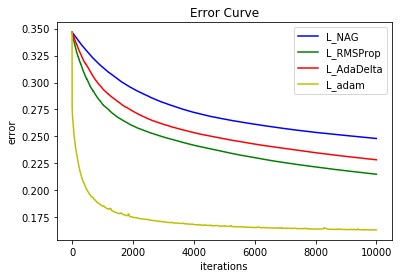

In [23]:
# Plot
plt.plot(L_NAG,'b',label='L_NAG')
plt.plot(L_RMSProp,'g',label='L_RMSProp')
plt.plot(L_AdaDelta,'r',label='L_AdaDelta')
plt.plot(L_adam,'y',label='L_adam')
plt.title('Loss Curve') # give plot a title
plt.xlabel('Iterations')# make axis labels
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
print('\n---------Assessment Result---------\ntraining accuracy_NAG=',training_accuracy_NAG,
      '\ntraining accuracy_RMSProp=',training_accuracy_RMSProp,
      '\ntraining accuracy_AdaDelta=',training_accuracy_AdaDelta,
      '\ntraining accuracy_Adam=',training_accuracy_Adam)

print('\n---------Predicted Results---------\ntest accuracy_NAG=',test_accuracy_NAG,
      '\ntest accuracy_RMSProp=',test_accuracy_RMSProp,
      '\ntest accuracy_AdaDelta=',test_accuracy_AdaDelta,
      '\ntest accuracy_Adam=',test_accuracy_Adam)


---------Assessment Result---------
training accuracy_NAG= 0.7591904425539756 
training accuracy_RMSProp= 0.7800128988667424 
training accuracy_AdaDelta= 0.761063849390375 
training accuracy_Adam= 0.84447652099137

---------Predicted Results---------
test accuracy_NAG= 0.7637737239727289 
test accuracy_RMSProp= 0.7841041705054972 
test accuracy_AdaDelta= 0.7651249923223389 
test accuracy_Adam= 0.8501934770591487
